In [3]:
using Flux, Flux.Data.MNIST, Images
using Flux: onehotbatch, argmax, mse, throttle
using Base.Iterators: partition
using Images

In [4]:
gpu(x) = x
# using CuArrays
# gpu(x) = cu(x)

gpu (generic function with 1 method)

For this model we'll learn a compression scheme. The idea is to encode MNIST digits as small vectors that can then be decoded back into the original image.

In [5]:
imgs = MNIST.images()
vecs = float.(vec.(imgs))

# Partition into batches of size 1000
data = [gpu(hcat(vecs[i]...)) for i in partition(1:60_000, 1000)];
vecs = gpu.(vecs);

,,,,,,,,,

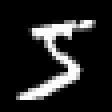
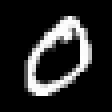
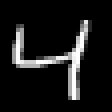
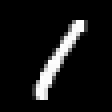
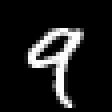
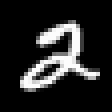
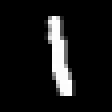
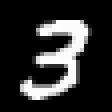
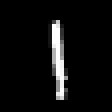
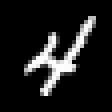

In [6]:
imgs[1:10]

In [7]:
N = 32 # Size of the encoding

encoder = Dense(28^2, N, relu)
decoder = Dense(N, 28^2, relu)

m = gpu(Chain(encoder, decoder))

loss(x) = mse(m(x), x)

loss (generic function with 1 method)

It's useful to be able to visualise what's happening in the network.

In [8]:
gray(x) = Gray(x)
img(x::AbstractVector) = collect(gray.(reshape(clamp.(x, 0, 1), 28, 28)))

img (generic function with 1 method)

First image:

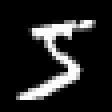

In [9]:
imgs[1]

Round-trip through the model:

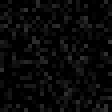

In [10]:
img(m(vecs[1]).data)

Random selection of 20 images:

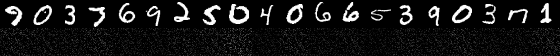

In [11]:
function sample()
  # 20 random digits
  xs = [vecs[i] for i in rand(1:length(imgs), 20)]
  # Before and after images
  before, after = img.(xs), img.(map(x -> m(x).data, xs))
  # Stack them all together
  hcat(vcat.(before, after)...)
end
sample()

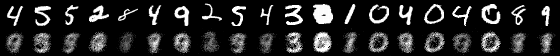

Loss is 84.51553446527802 (tracked)

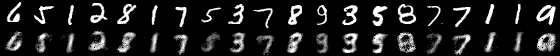

Loss is 49.39084705260831 (tracked)

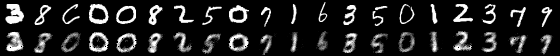

Loss is 34.90859335976474 (tracked)

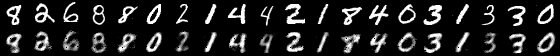

Loss is 27.181090044266636 (tracked)

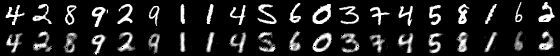

Loss is 20.83495601238839 (tracked)

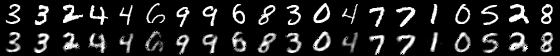

Loss is 15.78904685646133 (tracked)

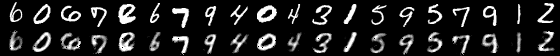

Loss is 12.10769393185691 (tracked)

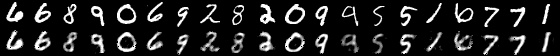

Loss is 9.25344489403972 (tracked)

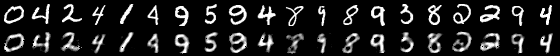

Loss is 6.822380812688085 (tracked)

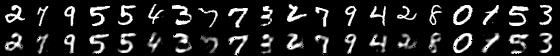

Loss is 4.859917961629159 (tracked)

In [12]:
evalcb = function ()
    print_with_color(:blue, "Loss is $(loss(data[1][1]))")
    display(sample())
end
opt = ADAM(params(m))

for i = 1:10
    Flux.train!(loss, zip(data), opt)
    evalcb()
end